In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) 

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy
from sklearn import metrics

# Data Pre-Processing

In [3]:
#to change directory
os.chdir("/mnt/c/Users/User/Downloads/")
os.getcwd()

'/mnt/c/Users/User/Downloads'

In [4]:
#load attributes csv file
attribute = pd.read_csv("celeba.csv")

#"attribute" is a dictionary containing several attributes for each image
#attribute.keys()

In [5]:
#let us list all the files in the image directory
path = "img_celeba_small"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant rows in attributes
attribute = attribute[:20000]

Number of images: 20000


## Creating training and validation datasets

In [6]:
# select first 15000 rows for training dataset
train = attribute[:15000]
train = train['Young']

# select last 5000 rows for test dataset
test = attribute[15000:20000]
test = test['Young']

In [7]:
is_Young = train==1
is_Old = train==-1

# subset training set by young/old
train_y = train[is_Young] 
train_o = train[is_Old]

len(train_o)

3331

Of the 15,000 images in the training data, 3331 are old. We will create a balanced dataset with all the old persons.

In [8]:
# sample 3331 observations from all young data in training set
onp.random.seed(0)
y_pindex = onp.random.choice(len(train_y), len(train_o), replace=False)
o_pindex = onp.asarray(list(range(3331)))

In [9]:
train_n = 2665
val_n = len(train_o) - train_n

# select prelim training & validation data
ptrain_y = train_y.iloc[y_pindex[:train_n]]
pval_y = train_y.iloc[y_pindex[train_n:]]

ptrain_o = train_o.iloc[o_pindex[:train_n]]
pval_o = train_o.iloc[o_pindex[train_n:]]

# collate prelim training data (3k obs, 1.5k each class)
ptrain = ptrain_y.append(ptrain_o)
ptrain = ptrain.sort_index()

# collate prelim test data (1k obs, .5k each class)
pval = pval_y.append(pval_o)
pval = pval.sample(frac=1)

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for old and young. 

`pval` is a 1 x 1332 array with the indicator values $\{-1, 1\}$ for old and young. 

## Loading images

The images were loaded in grayscale with an initial size of 218 by 178 pixels. The pixel intensity was then rescaled to [0,1]. To remove parts of the image irrelevant to a person's age (outside of the face), the images were cropped to only include the range [50:185, 40:135]. The final images used for analysis are 135 by 95 pixels.

In [10]:
h = 218 # original image height
w = 178 # original image weight
h_n = 185-50 # height after cropping
w_n = 135-40 # width after cropping

# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_img = onp.zeros((ntrain_img,h_n,w_n))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[50:185,40:135]
    ptrain_img[k,:,:] = im
    
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_img = onp.zeros((nval_img,h_n,w_n))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[50:185,40:135]
    pval_img[k,:,:] = im
    
# load the images from the test set
ntest_img = 5000
ptest_img = onp.zeros((ntest_img,h_n,w_n))

for k in range(ntest_img):
    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[50:185,40:135]
    ptest_img[k,:,:] = im

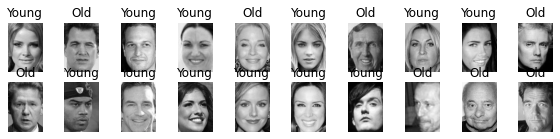

In [11]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptrain_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = ptrain.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

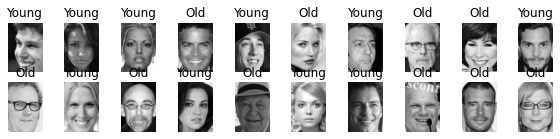

In [12]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = pval_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = pval.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

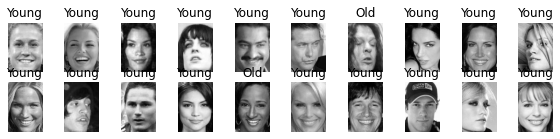

In [13]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptest_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = test.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for old and young. `ptrain_img` is a 5330 x 135 x 95 array that contains the relevant images for the preliminary training data. 

`pval` is a 1 x 1332 array with the indicator values $\{-1, 1\}$ for old and young. `pval_img`is a 1332 x 135 x 95 array that contains the relevant images for the preliminary validation data. 

`test` is a 1 x 5000 array with with the indicator values $\{-1, 1\}$ for old and young. `ptest_img`is a 5000 x 135 x 95 array that contains the relevant images for the preliminary validation data. 

In [16]:
data_train = ptrain_img.reshape(5330, h_n*w_n)
y_train = ptrain.to_numpy(copy=True)

data_val = pval_img.reshape(1332, h_n*w_n)
y_val = pval.to_numpy(copy=True)

data_test = ptest_img.reshape(5000, h_n*w_n)
y_test = test.to_numpy(copy=True)

In [17]:
#define functions
def prediction_single(beta, x): #log prob for a single x
    """ beta is a vector of dimension 3600, and x as well """
    proba = 1. / (1. + np.exp(-np.dot(beta, x)))
    return proba

#make a prediction on a whole dataset, dont need to map for beta since beta is the same for all x,just need to map to the x
prediction_data = jax.vmap(prediction_single, in_axes=(None,0))

def loss_single(beta,x,y):#loss for a single exmaple
    """
    beta: vector of dimension 3600
    x: vector of dimension 3600
    y: a number that equals -1 or 1
    """
    return np.log(1. + np.exp(-y * np.dot(beta, x)))

#compute the loss on. whole dataset
loss_dataset = jax.vmap(loss_single, in_axes=(None,0,0))

def loss(beta, data, y): #loss for the whole dataset, is just the sum of all the losses at each datapoint
    """ compute the mean of all the individual losses """
    list_of_all_losses = loss_dataset(beta, data, y)
    return np.mean(list_of_all_losses) + np.mean(abs(beta))

def accuracy(beta, data, y): #we use our validation set here, we test our algo see how well it predicts on the validation set
    pred = prediction_data(beta, data)
    threshold = 0.5
    prediction_binary = (pred > 0.5).astype(int)  #equals 1 if pred > threshold and 0 otherwise
    prediction_sign = 2*(prediction_binary - 0.5) #equals 1 if pred > threshold and -1 otherwise
    #we use prediction sign bc we want -1 and 1 innstead of 1 and 0
    return np.mean(prediction_sign == y) #want to see how many is correct

grad_loss = jax.jit(jax.grad(loss,argnums = 0)) #to compute gradient of the loss function

## Constraint new lasso with backtracking



In [18]:
onp.random.seed(1)
beta_init = onp.random.normal(0,0.1,size=95*135)
beta = onp.copy(beta_init)

onp.random.seed(2)
beta_init_min =  onp.random.normal(0,0.1,size=95*135)

In [19]:
#backtracking:
n_iter = 2500
learning_rate = 10
loss_val4 = []
loss_train4 = []
acc_train_list4 =[]
acc_val_list4 = []
alpha= 0.5

beta_min = onp.copy(beta_init_min)
loss_val = loss(beta_min,data_val,y_val) #current minimum loss

for k in range(n_iter):
    #need to first compute descent direction
    gradient = grad_loss(beta,data_train,y_train)
    descent_direction = -gradient
    
    #adaptive learning rate
    learning_rate = learning_rate*3
    current_loss = loss(beta,data_train,y_train)
    while loss(beta+learning_rate*descent_direction,data_train,y_train)> current_loss+alpha*learning_rate*np.dot(descent_direction,gradient):
        learning_rate = learning_rate/2.
    
    #now do update:
    beta = beta+learning_rate* descent_direction
    
    accuracy_train = accuracy(beta,data_train,y_train)
    accuracy_val = accuracy(beta,data_val,y_val)
    current_loss_val = loss(beta,data_val,y_val)
    current_loss_train = loss(beta,data_train,y_train)
    
    if current_loss_val <=loss_val:
        beta_min=beta
        loss_val = current_loss_val
    
    acc_train_list4.append(accuracy_train)
    acc_val_list4.append(accuracy_val)
    loss_val4.append(current_loss_val)
    loss_train4.append(current_loss_train)


/home/joycelim98/.local/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [20]:
beta_lasso_latest = onp.copy(beta)

In [21]:
beta_lasso_latest

array([ 0.16072403, -0.0592157 , -0.05175688, ..., -0.03083435,
        0.04018236,  0.06149385])

In [22]:
beta_lasso_min = onp.copy(beta_min)

In [23]:
beta_lasso_min

DeviceArray([ 0.16072166, -0.05921978, -0.05176071, ..., -0.03083961,
              0.04017796,  0.06148616], dtype=float64)

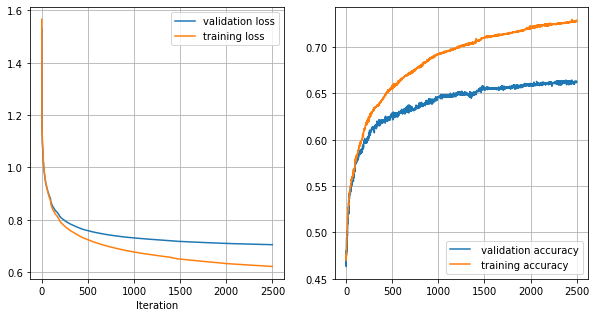

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(loss_val4,label = "validation loss")
plt.plot(loss_train4,label = "training loss")
plt.grid(True)
plt.xlabel("Iteration")
plt.legend(loc = "upper right")

plt.subplot(1,2,2)
plt.plot(acc_val_list4,label=" validation accuracy")
plt.plot(acc_train_list4,label = " training accuracy")
plt.grid(True)
plt.legend(loc = "lower right")


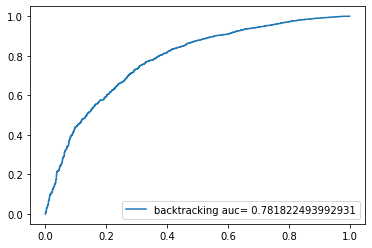

In [25]:
#auc curve
y_pred_proba = prediction_data(beta_lasso_latest,data_test)
fpr,tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
auc = metrics.roc_auc_score(y_test,y_pred_proba)
plt.plot(fpr,tpr,label="backtracking auc= "+str(auc))
plt.legend(loc=4)
plt.show()


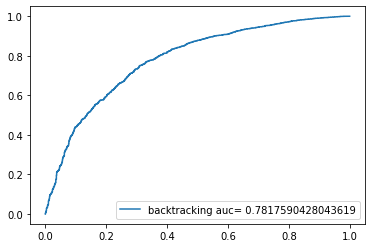

In [26]:
#auc curve
y_pred_proba = prediction_data(beta_lasso_min,data_test)
fpr,tpr, _ = metrics.roc_curve(y_test,y_pred_proba)
auc = metrics.roc_auc_score(y_test,y_pred_proba)
plt.plot(fpr,tpr,label="backtracking auc= "+str(auc))
plt.legend(loc=4)
plt.show()


In [27]:
def accuracy1(beta,data,y,threshold):
    pred = prediction_data(beta,data)
    prediction_binary = (pred>threshold).astype(int)
    prediction_sign = 2*(prediction_binary-0.5)
    return np.mean(prediction_sign == y)

t=list(range(1,10))
for i in t:
    print(accuracy1(beta_lasso_min,data_test,y_test,i/10)) #the minimum validation beta

0.804
0.8062
0.8004
0.7708
0.7166
0.6398
0.5512
0.4358
0.306


In [28]:
def accuracy1(beta,data,y,threshold):
    pred = prediction_data(beta,data)
    prediction_binary = (pred>threshold).astype(int)
    prediction_sign = 2*(prediction_binary-0.5)
    return np.mean(prediction_sign == y)

t=list(range(1,10))
for i in t:
    print(accuracy1(beta_lasso_latest,data_test,y_test,i/10)) #the minimum validation beta

0.8036
0.8058
0.8002
0.7736
0.7184
0.6428
0.553
0.4392
0.3076


In [ ]:
df = pd.DataFrame({"loss_history_val":loss_val4,
                  "loss_history_train":loss_train4,
                  "accuracy_train": acc_train_list4,
                  "accuracy_val":acc_val_list4})

df.to_csv("lassobacktrack.csv")

In [ ]:
df_beta = pd.DataFrame({"beta_lasso_latest":beta_lasso_latest,
                       "beta_lasso_min":beta_lasso_min})

df_beta.to_csv("beta_lassobacktrack.csv")